<a href="https://colab.research.google.com/github/AgusEtchissure/Tesis_Bullfrog_AE/blob/main/bullfrog_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Packages**

In [ ]:
%%capture
# Paquete de Python que facilita la manipulación de datos terrestres
!pip install earthpy

# Librería Basemap
# !pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1" "basemap-data-hires == 1.3.0b1"

# Raster managing package installing
!pip install rioxarray

# Basemap tiles package
!pip3 install contextily

# Auxiliary functions for geopandas
!pip install rtree

# Function to extract zip files
import zipfile

In [ ]:
# Se importan funciones auxiliares desde GitHub requeridas para el desarrollo de
# este práctico
!git clone https://github.com/jsblandon/weather_data_uy_preprocessing.git
import sys
sys.path.append('/content/weather_data_uy_preprocessing')

Cloning into 'weather_data_uy_preprocessing'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 2), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 4.80 KiB | 613.00 KiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
# Para cargarlos desde un .zip
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ruta JUAN
!unzip /content/drive/MyDrive/research/data/Rana\ Toro/bullfrog_data.zip
!unzip /content/drive/MyDrive/research/data/Rana\ Toro/charcos_tres_vecinos.zip
!unzip /content/drive/MyDrive/research/data/Rana\ Toro/vecinos_charcos.zip

Archive:  /content/drive/MyDrive/research/data/Rana Toro/bullfrog_data.zip
  inflating: acegua-2007.tif         
  inflating: acegua-2012.tif         
  inflating: acegua-2017.tif         
  inflating: acegua-2022.tif         
 extracting: Charcos_2007.cpg        
  inflating: Charcos_2007.dbf        
  inflating: Charcos_2007.prj        
  inflating: Charcos_2007.sbn        
  inflating: Charcos_2007.sbx        
  inflating: Charcos_2007.shp        
  inflating: Charcos_2007.shp.xml    
  inflating: Charcos_2007.shx        
 extracting: Charcos_2012.cpg        
  inflating: Charcos_2012.dbf        
  inflating: Charcos_2012.prj        
  inflating: Charcos_2012.sbn        
  inflating: Charcos_2012.sbx        
  inflating: Charcos_2012.shp        
  inflating: Charcos_2012.shp.xml    
  inflating: Charcos_2012.shx        
 extracting: Charcos_2017.cpg        
  inflating: Charcos_2017.dbf        
  inflating: Charcos_2017.prj        
  inflating: Charcos_2017.sbn        
  inflating: 

In [ ]:
import os                          # directory managing
from glob import glob              # files managing
import contextily as cx            # basemap tiles
import geopandas as gpd            # shapefile managing
import matplotlib.colors as colors # customize colors
import matplotlib.pyplot as plt    # plots
import matplotlib.font_manager as fm # cutom fonts
import numpy as np                 # array managing
import pandas as pd                # structured data managing
import xarray as xr                # labelled multi-dimensional arrays
import rasterio as rio             # rastewr managing
import rioxarray as rxr            # raster managing
import seaborn as sns              # plots
from geopandas import GeoDataFrame
from matplotlib.colors import ListedColormap
from natsort import natsorted      # natural sorting strings
from urllib.request import urlopen # requests managing
from io import BytesIO             # file managing
from pandas import DataFrame       # pandas dataframe structure
from rasterio.plot import show     # plotting from rasterio
from matplotlib import colors, patches
from shapely.geometry import mapping, Point, Polygon # for clipping rasters using shapes and geometries managing
from shapely import geometry       # geomtric operations and managing
from tqdm import tqdm              # Progress tracking
from urllib.error import HTTPError # Error handler
from warnings import simplefilter  # get rid off warnings
from weather_data_preprocessing import null_report
from zipfile import ZipFile        # .zip files managing


# ML STAGE PACKAGES
from lightgbm import LGBMClassifier
from sklearn import model_selection

from sklearn.preprocessing import OneHotEncoder # to encode categotrical data
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm

In [ ]:
# Plot settings
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

sns.set_style('whitegrid')
simplefilter("ignore")

## **Functions**

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    f""" Funcion para guardar figuras eficientemente

        Recibe
        ------
        fig_id : string
            Identificador de la figura

        Devuelve
        --------
        Figura almacenada en el directorio de trabajo

        Fuente: Géron, A. (2022). Hands-on machine learning with Scikit-Learn,
        Keras, and TensorFlow. " O'Reilly Media, Inc.".

    """
    path =  f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution,bbox_inches="tight",transparent=True)

# <center><b>DATA PREPROCESSING</b></center>

## <b>Time-based approach</b>

In [ ]:
# Shape loadings
lst_charcos = glob(os.path.join(os.getcwd(),"*Charcos_*.shp"))
lst_charcos.sort()
charcos_acegua = [gpd.read_file(i) for i in lst_charcos]

In [ ]:
charcos_acegua[0].crs

<Projected CRS: EPSG:32721>
Name: WGS 84 / UTM zone 21S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 60°W and 54°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Falkland Islands (Malvinas). Paraguay. Uruguay.
- bounds: (-60.0, -80.0, -54.0, 0.0)
Coordinate Operation:
- name: UTM zone 21S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# Raster loading
lst_rasters = glob(os.path.join(os.getcwd(),"*acegua-*.tif"))
lst_rasters.sort()

# For visualization purposes
raster_vis = [rxr.open_rasterio(i, masked = True).squeeze() for i in lst_rasters]
# For operative purposes
raster_op = [rio.open(i) for i in lst_rasters]

In [ ]:
# Renaming label columns
charcos_acegua[0].rename(columns={"Inv_2007": "2007"}, inplace = True)
charcos_acegua[1].rename(columns={"Inv_2012": "2012"}, inplace = True)
charcos_acegua[2].rename(columns={"Inv_2017": "2017"}, inplace = True)
charcos_acegua[3].rename(columns={"Inv_2022": "2022"}, inplace = True)

In [ ]:
# Year list
y = ['2007','2012','2017','2022']
df_charcos_acegua_us = charcos_acegua[0]

for i in range(1,len(charcos_acegua)):
    df_charcos_acegua_us = df_charcos_acegua_us.sjoin(
        # Left GeoDataFrame
        charcos_acegua[i],
        # Right GeoDataFrames got more locations
        how="right",
        # We are looking for intersections
        predicate='intersects',
        # Identifier for variables from first GeoDataFrame
        lsuffix = y[i-1],
        # Identifier for variables from second GeoDataFrame
        rsuffix = y[i])

# Retrieving the variables
df_charcos_acegua_us = df_charcos_acegua_us[['TIPO_OBJET_2022',
                                             'Charco_2022',
                                             'x_coord_2022',
                                             'y_coord_2022',
                                             '2007',
                                             '2012',
                                             '2017',
                                             '2022',
                                             'Abundancia_2007',
                                             'Abundancia_2012',
                                             'Abundancia_2017',
                                             'Abundancia_2022',
                                             'geometry']]

# Renaming columns
df_charcos_acegua_us.rename(columns={'TIPO_OBJET_2022':'TIPO_OBJET',
                                     'Charco_2022':'Charco',
                                     'x_coord_2022':'x_coord',
                                     'y_coord_2022':'y_coord',
                                     '2007':'Inv_2007',
                                     '2012':'Inv_2012',
                                     '2017':'Inv_2017',
                                     '2022':'Inv_2022'}, inplace =True)

In [ ]:
# CRS raster checking
with rio.open(lst_rasters[0]) as src:
    raster_crs = src.crs
raster_crs

CRS.from_epsg(4326)

In [ ]:
# Reprojecting
df_charcos_acegua_us = df_charcos_acegua_us.to_crs(raster_crs)

In [ ]:
# Data sampling from rasters to shapes
y = ['2007','2012','2017','2022']

for i in range(0,len(y)):
    coord_list = [(x, y) for x, y in zip(df_charcos_acegua_us["geometry"].x,
                                         df_charcos_acegua_us["geometry"].y)]
    df_charcos_acegua_us["LULC_val"+"_"+y[i]] = [x for x in raster_op[i].sample(coord_list)]

In [ ]:
#Creation of a new column "LULC_label" and assignment of labels based on the column "LULC_val"
for index, row in df_charcos_acegua_us.iterrows():
  if row['LULC_val_2007'] == 3:
      df_charcos_acegua_us.at[index, 'LULC_label_2007'] = 'Formación forestal cerrada'
  elif row['LULC_val_2007'] == 9:
      df_charcos_acegua_us.at[index, 'LULC_label_2007'] = 'Plantación forestal'
  elif row['LULC_val_2007'] == 11:
      df_charcos_acegua_us.at[index, 'LULC_label_2007'] = 'Zona pantanosa o pastizal inundable'
  elif row['LULC_val_2007'] == 12:
      df_charcos_acegua_us.at[index, 'LULC_label_2007'] = 'Pastizal'
  elif row['LULC_val_2007'] == 14:
      df_charcos_acegua_us.at[index, 'LULC_label_2007'] = 'Área agropecuaria'
  elif row['LULC_val_2007'] == 22:
      df_charcos_acegua_us.at[index, 'LULC_label_2007'] = 'Área no vegetada'
  elif row['LULC_val_2007'] == 27:
      df_charcos_acegua_us.at[index, 'LULC_label_2007'] = 'No observado'
  elif row['LULC_val_2007'] == 33:
      df_charcos_acegua_us.at[index, 'LULC_label_2007'] = 'Río, lago u océano'

for index, row in df_charcos_acegua_us.iterrows():
  if row['LULC_val_2012'] == 3:
      df_charcos_acegua_us.at[index, 'LULC_label_2012'] = 'Formación forestal cerrada'
  elif row['LULC_val_2012'] == 9:
      df_charcos_acegua_us.at[index, 'LULC_label_2012'] = 'Plantación forestal'
  elif row['LULC_val_2012'] == 11:
      df_charcos_acegua_us.at[index, 'LULC_label_2012'] = 'Zona pantanosa o pastizal inundable'
  elif row['LULC_val_2012'] == 12:
      df_charcos_acegua_us.at[index, 'LULC_label_2012'] = 'Pastizal'
  elif row['LULC_val_2012'] == 14:
      df_charcos_acegua_us.at[index, 'LULC_label_2012'] = 'Área agropecuaria'
  elif row['LULC_val_2012'] == 22:
      df_charcos_acegua_us.at[index, 'LULC_label_2012'] = 'Área no vegetada'
  elif row['LULC_val_2012'] == 27:
      df_charcos_acegua_us.at[index, 'LULC_label_2012'] = 'No observado'
  elif row['LULC_val_2012'] == 33:
      df_charcos_acegua_us.at[index, 'LULC_label_2012'] = 'Río, lago u océano'

for index, row in df_charcos_acegua_us.iterrows():
  if row['LULC_val_2017'] == 3:
      df_charcos_acegua_us.at[index, 'LULC_label_2017'] = 'Formación forestal cerrada'
  elif row['LULC_val_2017'] == 9:
      df_charcos_acegua_us.at[index, 'LULC_label_2017'] = 'Plantación forestal'
  elif row['LULC_val_2017'] == 11:
      df_charcos_acegua_us.at[index, 'LULC_label_2017'] = 'Zona pantanosa o pastizal inundable'
  elif row['LULC_val_2017'] == 12:
      df_charcos_acegua_us.at[index, 'LULC_label_2017'] = 'Pastizal'
  elif row['LULC_val_2017'] == 14:
      df_charcos_acegua_us.at[index, 'LULC_label_2017'] = 'Área agropecuaria'
  elif row['LULC_val_2017'] == 22:
      df_charcos_acegua_us.at[index, 'LULC_label_2017'] = 'Área no vegetada'
  elif row['LULC_val_2017'] == 27:
      df_charcos_acegua_us.at[index, 'LULC_label_2017'] = 'No observado'
  elif row['LULC_val_2017'] == 33:
      df_charcos_acegua_us.at[index, 'LULC_label_2017'] = 'Río, lago u océano'

for index, row in df_charcos_acegua_us.iterrows():
  if row['LULC_val_2022'] == 3:
      df_charcos_acegua_us.at[index, 'LULC_label_2022'] = 'Formación forestal cerrada'
  elif row['LULC_val_2022'] == 9:
      df_charcos_acegua_us.at[index, 'LULC_label_2022'] = 'Plantación forestal'
  elif row['LULC_val_2022'] == 11:
      df_charcos_acegua_us.at[index, 'LULC_label_2022'] = 'Zona pantanosa o pastizal inundable'
  elif row['LULC_val_2022'] == 12:
      df_charcos_acegua_us.at[index, 'LULC_label_2022'] = 'Pastizal'
  elif row['LULC_val_2022'] == 21:
      df_charcos_acegua_us.at[index, 'LULC_label_2022'] = 'Área agropecuaria'
  elif row['LULC_val_2022'] == 22:
      df_charcos_acegua_us.at[index, 'LULC_label_2022'] = 'Área no vegetada'
  elif row['LULC_val_2022'] == 27:
      df_charcos_acegua_us.at[index, 'LULC_label_2022'] = 'No observado'
  elif row['LULC_val_2022'] == 33:
      df_charcos_acegua_us.at[index, 'LULC_label_2022'] = 'Río, lago u océano'

In [ ]:
# Missing values
null_report(df_charcos_acegua_us)

,variables,null_values
0,TIPO_OBJET,2.052786
1,Charco,0.000000
2,x_coord,0.000000
3,y_coord,0.000000
4,Inv_2007,4.692082
5,Inv_2012,2.346041
6,Inv_2017,0.293255
7,Inv_2022,0.000000
8,Abundancia_2007,97.360704
9,Abundancia_2012,95.894428


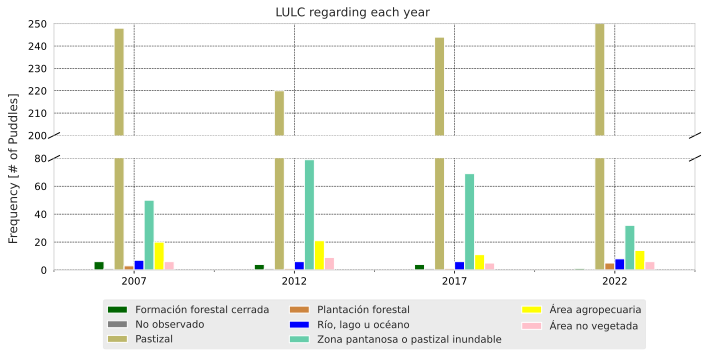

In [ ]:
# Occupation frequency vs LULC

conteo_usos_periodos = df_charcos_acegua_us[['LULC_label_2007','LULC_label_2012', 'LULC_label_2017', 'LULC_label_2022']].apply(pd.Series.value_counts)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize = (10,5))
fig.subplots_adjust(hspace=0.1)

colores = [
          'darkgreen',
          'grey',
          'darkkhaki',
          'peru',
          'blue',
          'mediumaquamarine',
          'yellow',
          'pink',
          ]

plt.suptitle("LULC regarding each year", y = 0.95)

conteo_usos_periodos.transpose().plot.bar(ax = ax1, color = colores, legend = False)
conteo_usos_periodos.transpose().plot.bar(ax = ax2, color = colores, legend = False)

ax2.set_ylim(0, 80)  # outliers only
ax1.set_ylim(200, 250)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Configurar los ejes mayores de x e y para que estén de color negro
ax1.tick_params(axis='y', colors='black')
ax2.tick_params(axis='both', colors='black')

# Configurar las líneas del grid como punteadas
ax1.grid(which='major', linestyle='dashed', linewidth='0.5', color='black')
ax2.grid(which='major', linestyle='dashed', linewidth='0.5', color='black')



d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

new_xtick_labels = ["2007","2012","2017","2022"]
ax2.set_xticklabels(new_xtick_labels, rotation=0)


# Leyenda a la derecha
handles, labels = ax2.get_legend_handles_labels()
legend = ax2.legend(handles, labels, loc='lower center',  bbox_to_anchor=(0.5, -0.75),ncol=3)
legend.get_frame().set_edgecolor('.9')
legend.get_frame().set_facecolor('0.9')
fig.supylabel("Frequency [# of Puddles]")
save_fig("lulc_years_acegua",fig_extension="svg")
save_fig("lulc_years_acegua",fig_extension="png")
plt.show()

## <b>Spatial-based approach</b>

In [ ]:
# Loading neighbor data
lst_neighbors = glob(os.path.join(os.getcwd() + '/charcos_tres_vecinos',"*3vecinos_*.csv"))
lst_neighbors.sort()
neighbor_puddles = [pd.read_csv(i, delimiter=';', decimal=',', encoding='UTF-8') for i in lst_neighbors]

In [ ]:
# Loading neighbor data
neighbor_puddles = []
years = ['2007','2012','2017','2022']

for year in years:
    puddle = glob(os.path.join(os.getcwd() + '/' + year + '/',"3vecinos_" + year + ".shp"))
    neighbor_puddles += [gpd.read_file(puddle[0])]

In [ ]:
# Raster loading
lst_rasters = glob(os.path.join(os.getcwd(),"*acegua-*.tif"))
lst_rasters.sort()

# For visualization purposes
raster_vis = [rxr.open_rasterio(i, masked = True).squeeze() for i in lst_rasters]
# For operative purposes
raster_op = [rio.open(i) for i in lst_rasters]

# CRS raster checking
with rio.open(lst_rasters[0]) as src:
    raster_crs = src.crs
raster_crs

CRS.from_epsg(4326)

In [ ]:
# Assigning index to each dataframe
for i in range(0,len(neighbor_puddles)):
    neighbor_puddles[i]['ID'] = neighbor_puddles[i].index

In [ ]:
# # From DataFrame into GeoDataFrame
# for i in range(0,len(neighbor_puddles)):
#     geometry = [Point(xy) for xy in zip(neighbor_puddles[i]['X_COORD'], neighbor_puddles[i]['Y_COORD'])]
#     neighbor_puddles[i] = GeoDataFrame(neighbor_puddles[i], crs=crs_shp_puddles.crs, geometry=geometry)

In [ ]:
# Retrieving variables
years = ['2007','2012','2017','2022']

for i in range(0,len(years)):
    neighbor_puddles[i] = neighbor_puddles[i].loc[:,['Inv_' + years[i],'Inv_Label_','Inv_Labe_1','Inv_Labe_2','geometry']]
    neighbor_puddles[i].rename(columns={'Inv_' + years[i]:'State',
                                        'Inv_Label_':'N1',
                                        'Inv_Labe_1':'N2',
                                        'Inv_Labe_2':'N3'}, inplace = True)

In [ ]:
# Year list
y = ['2007','2012','2017','2022']
df_neighbor_puddles = neighbor_puddles[0]

for i in range(1,len(neighbor_puddles)):
    df_neighbor_puddles = df_neighbor_puddles.sjoin(
        # Left GeoDataFrame
        neighbor_puddles[i],
        # Right GeoDataFrames got more locations
        how="right",
        # We are looking for intersections
        predicate='intersects',
        # Identifier for variables from first GeoDataFrame
        lsuffix = y[i-1],
        # Identifier for variables from second GeoDataFrame
        rsuffix = y[i])

df_neighbor_puddles.drop(columns = ['index_2017','index_2012','index_2007'], inplace = True)

In [ ]:
# Reprojecting
df_neighbor_puddles = df_neighbor_puddles.to_crs(raster_crs)

In [ ]:
# Data sampling from rasters to shapes
y = ['2007','2012','2017','2022']

for i in range(0,len(y)):
    coord_list = [(x, y) for x, y in zip(df_neighbor_puddles["geometry"].x,
                                         df_neighbor_puddles["geometry"].y)]
    df_neighbor_puddles["LULC_val"+"_"+y[i]] = [x for x in raster_op[i].sample(coord_list)]

In [ ]:
# Data conversion
years = ['2007','2012','2017','2022']

for year in years:
    df_neighbor_puddles['LULC_val_' + year] = df_neighbor_puddles['LULC_val_' + year].astype(int)

In [ ]:
#  GeoDataFrame checking
df_neighbor_puddles

,State_2007,N1_2007,N2_2007,N3_2007,State_2012,N1_2012,N2_2012,N3_2012,State_2017,N1_2017,...,N3_2017,State_2022,N1_2022,N2_2022,N3_2022,geometry,LULC_val_2007,LULC_val_2012,LULC_val_2017,LULC_val_2022
0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1,1,1,0,POINT (-54.15229 -31.89952),11,11,11,11
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1,1,1,0,POINT (-54.15004 -31.89565),12,14,12,12
2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1,1,1,1,POINT (-54.16611 -31.87632),12,12,12,22
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,POINT (-54.17197 -31.86429),12,12,12,12
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0,0,0,POINT (-54.13780 -31.91034),12,12,11,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,POINT (-54.11583 -31.89649),12,12,12,12
337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,POINT (-54.13346 -31.88304),3,3,12,12
338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,POINT (-54.13552 -31.88041),3,3,12,12
339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,POINT (-54.11825 -31.91939),12,12,14,21


In [ ]:
# Columns checking
df_neighbor_puddles.columns

Index(['State_2007', 'N1_2007', 'N2_2007', 'N3_2007', 'State_2012', 'N1_2012',
       'N2_2012', 'N3_2012', 'State_2017', 'N1_2017', 'N2_2017', 'N3_2017',
       'State_2022', 'N1_2022', 'N2_2022', 'N3_2022', 'geometry',
       'LULC_val_2007', 'LULC_val_2012', 'LULC_val_2017', 'LULC_val_2022'],
      dtype='object')

# <center><b>MODEL TRAINING/TESTING</b></center>

## <b>Training/Testing Splitting: LULC and Invasion State Variables</b>

Se va a descartar el $\texttt{TIPO OBJECT}$ como variable. Las coordenadas permitirán calcular la cercanía entre charcos mediante vecinos más cercanos. Las etiquetas estarán dadas por la invasión (aproximación de presencia/ausencia). Dado que se va a hacer clasificación, hay que preservar una de las dos variables; esto es:

*   Si se predicen probabilidades de ocupación de charcos, se estará hablando de **Clasificación** (variables $\texttt{Inv_}$)
*   Si se predice la abudancia en los charcos, se estará hablando de **Regresión** (variables $\texttt{Abundancia_}$)

Las variables $\texttt{LULC_label_}$ se eliminarán del DataFrame, en tanto que se usan para efectos de generar gráficas.


In [ ]:
# Selección de las variables
df_charcos_pred = df_charcos_acegua_us[['x_coord', 'y_coord', 'Inv_2007', 'Inv_2012',
                                        'Inv_2017', 'Inv_2022', 'geometry', 'LULC_val_2007',
                                        'LULC_val_2012', 'LULC_val_2017', 'LULC_val_2022']]

A efecto de entender el código que se implementa a continuación, vamos a esquematizar lo que estamos haciendo para darle al modelo información histórica sobre el uso de suelo y el estado de invasión a efectos de predecir la invasión o no de los charcos:

```
X_train = df_charcos_pred[['Inv_2007','LULC_val_2007','LULC_val_2012']]
y_train = df_charcos_pred['Inv_2012']

X_train = df_charcos_pred[['Inv_2012','LULC_val_2012','LULC_val_2017']]
y_train = df_charcos_pred['Inv_2017']

X_test =  df_charcos_pred[['Inv_2017','LULC_val_2017','LULC_val_2022']]
y_test = df_charcos_pred['Inv_2022']
```



In [ ]:
# TRAIN SPLIT

lst_years = [['2007','2012'],['2012','2017']]
lst = ['(t-1)','(t)']

charcos_dict = {'geometry':[],
                'Inv(t-1)':[],
                'LULC(t-1)':[],
                'LULC(t)':[],
                'Inv(t)':[]}

df_charcos_pred_train = pd.DataFrame(columns = list(charcos_dict.keys()))

for j in range(0,df_charcos_pred.shape[0]):
    for i in lst_years:
        charcos_dict = {'geometry':[],
                'Inv(t-1)':[],
                'LULC(t-1)':[],
                'LULC(t)':[],
                'Inv(t)':[]}

        for cont,k in enumerate(i):
            charcos_dict['geometry']=df_charcos_pred.loc[j,'geometry']
            charcos_dict['Inv'+lst[cont]] = df_charcos_pred.loc[j,'Inv_'+k]
            charcos_dict['LULC'+lst[cont]]=df_charcos_pred.loc[j,'LULC_val_'+k][0]

        df_charcos_pred_train = pd.concat([df_charcos_pred_train, pd.DataFrame([charcos_dict])], ignore_index=True)

# GeoDataFrame conversion
df_charcos_pred_train = gpd.GeoDataFrame(df_charcos_pred_train,
                                         geometry=df_charcos_pred_train['geometry'],
                                         crs =df_charcos_pred.crs)

In [ ]:
# TEST SPLIT

lst_years = [['2017','2022']]
lst = ['(t-1)','(t)']

charcos_dict = {'geometry':[],
                'Inv(t-1)':[],
                'LULC(t-1)':[],
                'LULC(t)':[],
                'Inv(t)':[]}

df_charcos_pred_test = pd.DataFrame(columns = list(charcos_dict.keys()))

for j in range(0,df_charcos_pred.shape[0]):
    for i in lst_years:
        charcos_dict = {'geometry':[],
                'Inv(t-1)':[],
                'LULC(t-1)':[],
                'LULC(t)':[],
                'Inv(t)':[]}

        for cont,k in enumerate(i):
            charcos_dict['geometry']=df_charcos_pred.loc[j,'geometry']
            charcos_dict['Inv'+lst[cont]] = df_charcos_pred.loc[j,'Inv_'+k]
            charcos_dict['LULC'+lst[cont]]=df_charcos_pred.loc[j,'LULC_val_'+k][0]

        df_charcos_pred_test = pd.concat([df_charcos_pred_test, pd.DataFrame([charcos_dict])], ignore_index=True)

# GeoDataFrame conversion
df_charcos_pred_test = gpd.GeoDataFrame(df_charcos_pred_test,
                                         geometry=df_charcos_pred_test['geometry'],
                                         crs =df_charcos_pred.crs)

## <b>Model Training/Testing: LULC and Invasion State Variables</b>

In [ ]:
# Datos de entrenamiento
df_charcos_pred_train

,geometry,Inv(t-1),Inv_1(t-1),Inv_2(t-1),Inv_3(t-1),LULC(t-1),Inv_1(t),Inv_2(t),Inv_3(t),LULC(t),Inv(t)
0,POINT (769323.43760 6467163.63200),0.0,1.0,0.0,1.0,0,1.0,1.0,0.0,0,1.0
1,POINT (769323.43760 6467163.63200),1.0,1.0,1.0,0.0,0,1.0,1.0,0.0,0,1.0
2,POINT (769547.76670 6467586.99200),1.0,1.0,1.0,0.0,0,1.0,1.0,0.0,0,1.0
3,POINT (769547.76670 6467586.99200),1.0,1.0,1.0,0.0,0,1.0,1.0,0.0,0,1.0
4,POINT (768083.49020 6469770.35100),NaN,NaN,NaN,NaN,0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
677,POINT (770965.83970 6469240.34700),0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0
678,POINT (772485.76740 6464874.67600),0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0
679,POINT (772485.76740 6464874.67600),0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0
680,POINT (774099.58450 6463989.08700),0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0


In [ ]:
# Datos de test
df_charcos_pred_test

,geometry,Inv(t-1),LULC(t-1),LULC(t),Inv(t)
0,POINT Z (-54.15229 -31.89952 0.00000),1.0,11,11,1
1,POINT Z (-54.15004 -31.89565 0.00000),1.0,12,12,1
2,POINT Z (-54.16611 -31.87632 0.00000),1.0,12,22,1
3,POINT Z (-54.17197 -31.86429 0.00000),0.0,12,12,0
4,POINT Z (-54.13780 -31.91034 0.00000),0.0,11,12,1
...,...,...,...,...,...
336,POINT Z (-54.11583 -31.89649 0.00000),0.0,12,12,0
337,POINT Z (-54.13346 -31.88304 0.00000),0.0,12,12,0
338,POINT Z (-54.13552 -31.88041 0.00000),0.0,12,12,0
339,POINT Z (-54.11825 -31.91939 0.00000),0.0,14,21,0


In [ ]:
# Nul data train
null_report(df_charcos_pred_train)

,variables,null_values
0,geometry,0.000000
1,Inv(t-1),3.519062
2,LULC(t-1),0.000000
3,LULC(t),0.000000
4,Inv(t),1.319648


In [ ]:
# Null data test
null_report(df_charcos_pred_test)

,variables,null_values
0,geometry,0.000000
1,Inv(t-1),0.293255
2,LULC(t-1),0.000000
3,LULC(t),0.000000
4,Inv(t),0.000000


In [ ]:
# NaN values drop
df_charcos_pred_train.dropna(inplace=True)
df_charcos_pred_test.dropna(inplace=True)

In [ ]:
# One-hot-encoder declaration
ohe= OneHotEncoder(handle_unknown = 'ignore',sparse_output=False).set_output(transform="pandas")

In [ ]:
# OHE applied to train set
X_train = ohe.fit_transform(df_charcos_pred_train[['LULC(t-1)', 'LULC(t)']])
X_train = pd.concat([X_train,df_charcos_pred_train[['Inv(t-1)','geometry']]], axis = 1)

# OHE applied to test set
X_test = ohe.transform(df_charcos_pred_test[['LULC(t-1)', 'LULC(t)']])
X_test = pd.concat([X_test,df_charcos_pred_test[['Inv(t-1)','geometry']]], axis = 1)

In [ ]:
df_charcos_pred_test = df_charcos_pred_test.replace(21,14)

In [ ]:
# Targets
y_train = df_charcos_pred_train[['Inv(t)']].astype(int)
y_test = df_charcos_pred_test[['Inv(t)']].astype(int)

In [ ]:
# Pipeline declaration
pipe_lr = Pipeline([('LR', LogisticRegression(random_state=42))])
pipe_knn = Pipeline([('KNN', KNeighborsClassifier())])
pipe_svm = Pipeline([('SVM', svm.SVC(random_state=42))])
pipe_et = Pipeline([('ET', ExtraTreesClassifier())])
pipe_dt = Pipeline([('DT',DecisionTreeClassifier(random_state=42))])
pipe_rf = Pipeline([('RF',RandomForestClassifier(random_state=42))])
pipe_xgb = Pipeline([('XGB', XGBClassifier(random_state=42))])

In [ ]:
# Hyper-parameters set-up
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]

lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                  'LR__C': param_range_fl,
                  'LR__solver': ['liblinear']}]

knn_param_grid = [{'KNN__n_neighbors': param_range,
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]

svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'],
                   'SVM__C': param_range}]

et_param_grid = [{'ET__criterion': ['gini', 'entropy'],
                  'ET__min_samples_leaf': param_range,
                  'ET__max_depth': param_range,
                  'ET__min_samples_split': param_range[1:]}]

dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                  'DT__min_samples_leaf': param_range,
                  'DT__max_depth': param_range,
                  'DT__min_samples_split': param_range[1:]}]

rf_param_grid = [{'RF__min_samples_leaf': param_range,
                  'RF__max_depth': param_range,
                  'RF__min_samples_split': param_range[1:]}]

xgb_param_grid = [{'XGB__learning_rate': learning_rates,
                   'XGB__max_depth': param_range,
                   'XGB__min_child_weight': param_range[:2],
                   'XGB__subsample': param_range_fl,
                   'XGB__n_estimators': n_estimators}]

In [ ]:
# Cross-validation set-up

cv = 3
n_jobs = -1
verbose = 2
random_state = 42

lr_grid_search = RandomizedSearchCV(estimator=pipe_lr,
        param_distributions=lr_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs = n_jobs,
        verbose=verbose,
        random_state=random_state)

knn_grid_search = RandomizedSearchCV(estimator=pipe_knn,
        param_distributions=knn_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs = n_jobs,
        verbose=verbose,
        random_state=random_state)

svm_grid_search = RandomizedSearchCV(estimator=pipe_svm,
        param_distributions=svm_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs = n_jobs,
        verbose=verbose,
        random_state=random_state)

et_grid_search = RandomizedSearchCV(estimator=pipe_et,
        param_distributions=et_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs = n_jobs,
        verbose=verbose,
        random_state=random_state)

dt_grid_search = RandomizedSearchCV(estimator=pipe_dt,
        param_distributions=dt_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs = n_jobs,
        verbose=verbose,
        random_state=random_state)

rf_grid_search = RandomizedSearchCV(estimator=pipe_rf,
        param_distributions=rf_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs = n_jobs,
        verbose=verbose,
        random_state=random_state)

xgb_grid_search = RandomizedSearchCV(estimator=pipe_xgb,
        param_distributions=xgb_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs = n_jobs,
        verbose=verbose,
        random_state=random_state)

In [ ]:
%%time
# Randomized Search applied
grid_dict = {'Logistic Regression': lr_grid_search,
             'K-Nearest Neighbors' : knn_grid_search,
             'Support Vector Machines' : svm_grid_search,
             'Extra Trees' : et_grid_search,
             'Decision Trees':dt_grid_search,
             'Random Forest': rf_grid_search,
             'XGBoost':xgb_grid_search}

for model, pipe in grid_dict.items():
    print('--------------------------------------------------------------')
    print('Model: ',model)
    pipe.fit(X_train.drop(['geometry'],axis=1), y_train)
    print('Done')

--------------------------------------------------------------
Model:  Logistic Regression
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Done
--------------------------------------------------------------
Model:  K-Nearest Neighbors
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done
--------------------------------------------------------------
Model:  Support Vector Machines
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done
--------------------------------------------------------------
Model:  Extra Trees
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done
--------------------------------------------------------------
Model:  Decision Trees
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done
--------------------------------------------------------------
Model:  Random Forest
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done
--------------------------------------------------------------
Model:  XGB

In [ ]:
{'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__C': 1.0}



{'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__C': 1.0}

In [ ]:
lr = LogisticRegression(solver= 'liblinear', penalty = 'l1', C = 1.0)
lr.fit(X_train.drop(['geometry'],axis=1), y_train)



[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.83831614 0.
  0.         0.         0.         0.         6.37371614]]


In [ ]:
X_train

,LULC(t-1)_3,LULC(t-1)_9,LULC(t-1)_11,LULC(t-1)_12,LULC(t-1)_14,LULC(t-1)_22,LULC(t-1)_27,LULC(t-1)_33,LULC(t)_3,LULC(t)_9,LULC(t)_11,LULC(t)_12,LULC(t)_14,LULC(t)_22,LULC(t)_27,LULC(t)_33,Inv(t-1),geometry
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT Z (-54.15229 -31.89952 0.00000)
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,POINT Z (-54.15229 -31.89952 0.00000)
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,POINT Z (-54.15004 -31.89565 0.00000)
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,POINT Z (-54.15004 -31.89565 0.00000)
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,POINT Z (-54.16611 -31.87632 0.00000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,POINT Z (-54.13552 -31.88041 0.00000)
678,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,POINT Z (-54.11825 -31.91939 0.00000)
679,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,POINT Z (-54.11825 -31.91939 0.00000)
680,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,POINT Z (-54.10095 -31.92698 0.00000)


In [ ]:
for i,j in enumerate(lr.coef_[0]):
    print("Feature = " + str(i),"Coef =" + str(j))

Feature = 0 Coef =0.0
Feature = 1 Coef =0.0
Feature = 2 Coef =0.0
Feature = 3 Coef =0.0
Feature = 4 Coef =0.0
Feature = 5 Coef =0.0
Feature = 6 Coef =0.0
Feature = 7 Coef =0.0
Feature = 8 Coef =0.0
Feature = 9 Coef =0.0
Feature = 10 Coef =0.8383161423046112
Feature = 11 Coef =0.0
Feature = 12 Coef =0.0
Feature = 13 Coef =0.0
Feature = 14 Coef =0.0
Feature = 15 Coef =0.0
Feature = 16 Coef =6.37371614104775


En este enfoque, se nota que no aporta información relevante el LULC en el período anterior si no el actual. Esto tiene sentido porque claramente a la especie le importan las condiciones actuales (recursos disponibles en el momento). Además, se ve que es más importante el estado de invasión en el período anterior.

NOTA: CLARAMENTE ESTO ES PARA EL ENFOQUE ÚNICAMENTE TEMPORAL.

In [ ]:
X_train

,LULC(t-1)_3,LULC(t-1)_9,LULC(t-1)_11,LULC(t-1)_12,LULC(t-1)_14,LULC(t-1)_22,LULC(t-1)_27,LULC(t-1)_33,LULC(t)_3,LULC(t)_9,LULC(t)_11,LULC(t)_12,LULC(t)_14,LULC(t)_22,LULC(t)_27,LULC(t)_33,Inv(t-1),geometry
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,POINT Z (-54.15229 -31.89952 0.00000)
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,POINT Z (-54.15229 -31.89952 0.00000)
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,POINT Z (-54.15004 -31.89565 0.00000)
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,POINT Z (-54.15004 -31.89565 0.00000)
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,POINT Z (-54.16611 -31.87632 0.00000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,POINT Z (-54.13552 -31.88041 0.00000)
678,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,POINT Z (-54.11825 -31.91939 0.00000)
679,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,POINT Z (-54.11825 -31.91939 0.00000)
680,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,POINT Z (-54.10095 -31.92698 0.00000)


In [ ]:
# RESULTS
for model, pipe in grid_dict.items():

    print('--------------------------------------------------------------------\
    ------------------------------------------------------------------------\n')
    # Final model
    final_model = pipe.best_estimator_
    print('{} Best Params: {}\n'.format(model,pipe.best_params_))

    # Test
    y_pred = final_model.predict(X_test.drop(['geometry'],axis=1))
    y_pred = pd.DataFrame(y_pred.astype(int),columns=y_test.columns)

    # Performance metrics for binary classification
    print(classification_report(y_test, y_pred))

--------------------------------------------------------------------    ------------------------------------------------------------------------

Logistic Regression Best Params: {'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__C': 1.0}

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       304
           1       1.00      0.75      0.86        36

    accuracy                           0.97       340
   macro avg       0.99      0.88      0.92       340
weighted avg       0.97      0.97      0.97       340

--------------------------------------------------------------------    ------------------------------------------------------------------------

K-Nearest Neighbors Best Params: {'KNN__weights': 'distance', 'KNN__n_neighbors': 6, 'KNN__metric': 'euclidean'}

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       304
           1       1.00      0.72      0.84        36

    ac

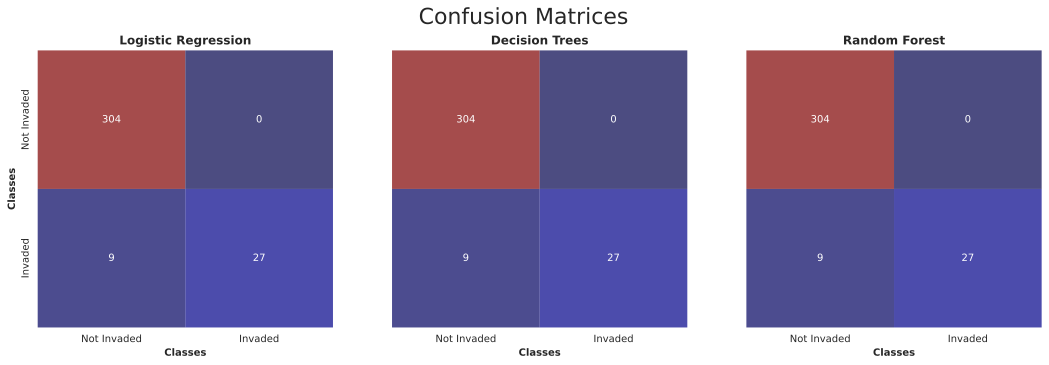

In [ ]:
# CONFUSION MATRICES
aux_grid_dict = {'Logistic Regression': lr_grid_search,
                 'Decision Trees':dt_grid_search,
                 'Random Forest': rf_grid_search}

iters = 0

fig, axis = plt.subplots(nrows=1, ncols=3,figsize=(18,5), sharey=True)
plt.suptitle("Confusion Matrices" , fontsize=22, y = 1.0)

# Confusion matrices
for model, pipe in aux_grid_dict.items():

    # Final model
    final_model = pipe.best_estimator_

    # Test
    y_pred = final_model.predict(X_test.drop(['geometry'],axis=1))
    y_pred = pd.DataFrame(y_pred.astype(int),columns=y_test.columns)

    # Confusion matrices computation and plotting
    classes = ['Not Invaded', 'Invaded']
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm.astype(int), columns=classes, index=classes)

    # Plotting
    plt.sca(axis[iters])
    plt.title(model, weight = 'bold')
    sns.heatmap(df_cm, annot=True, cmap = 'seismic',cbar = False,fmt='g',alpha=0.7)
    axis[iters].set_xlabel("Classes",weight='bold')
    axis[iters].grid(False)
    iters += 1

axis[0].set_ylabel("Classes",weight='bold')

# save_fig("confusion_matrices",fig_extension="svg")
# save_fig("confusion_matrices",fig_extension="png")
plt.show()

Para pintar las probabilidades de clase solo se hará para la Regresión Logística, en tanto que la forma como lo hacen los modelos basados en reglas (Decision Trees y Random Forests) es de tipo frecuentista, por lo que para comparaciones justas pintaremos si los charcos fueron ocupados o no para el período de interés considerando los tres modelos elegidos.

Respecto a la interpretabilidad, los modelos basados en reglas nos permitirán analizar las características (variables).

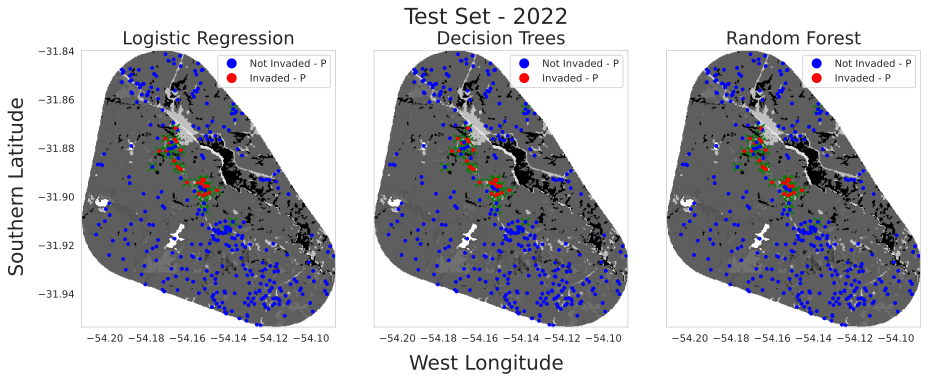

In [ ]:
# MAPS - LABELS
aux_grid_dict = {'Logistic Regression': lr_grid_search,
                 'Decision Trees':dt_grid_search,
                 'Random Forest': rf_grid_search}

iters = 0

fig, axis = plt.subplots(nrows=1, ncols=3,figsize=(18,5), sharey=True)
plt.suptitle("Test Set - 2022" , fontsize=22, y = 1.0)

# Removing pixels equal to 0
raster_vis_0 = raster_vis[0].where(raster_vis[0] != 0)

# Initializing auxiliar matrix
X_test_copy = X_test.copy()
X_test_copy['y_real'] = y_test.astype('category')
X_test_copy['y_real'].replace([0,1],["Not Invaded - R","Invaded - R"], inplace = True)

for model, pipe in aux_grid_dict.items():

    # Final model
    final_model = pipe.best_estimator_

    # Test
    y_pred = final_model.predict(X_test.drop(['geometry'],axis=1))
    y_pred = pd.DataFrame(y_pred.astype(int),columns=y_test.columns)

    # GeoDataFrame conversion
    X_test_copy[model+' label'] = y_pred.values
    X_test_copy[model+' label'] = X_test_copy[model+' label'].astype('category')
    X_test_copy[model+' label'].replace([0,1],["Not Invaded - P","Invaded - P"], inplace = True)
    X_test_copy = gpd.GeoDataFrame(X_test_copy,
                                   geometry=X_test_copy['geometry'],
                                   crs =df_charcos_pred.crs)

    # Plotting
    plt.sca(axis[iters])
    raster_vis_0.plot.imshow(ax=axis[iters], cmap='Greys_r')
    axis[iters].set_ylabel(' ')
    axis[iters].set_xlabel(' ')

    # Get current figure and axes
    fig = plt.gcf()
    ax = plt.gca()

    # Remove colorbar from raster
    cax = fig.axes[-1]
    fig.delaxes(cax)

    axis[iters].set_title(model, fontsize=18)
    X_test_copy[X_test_copy['y_real'] == 'Invaded - R'].plot(ax=axis[iters], markersize=70, column='y_real', color = 'g', marker = 'x',legend=False)
    X_test_copy.plot(ax=axis[iters], markersize=8, column=model+' label', cmap= 'bwr', legend=True)
    axis[iters].grid(False)
    iters += 1

fig.supxlabel('West Longitude',fontsize=20,y=-0.02)
fig.supylabel('Southern Latitude',fontsize=20,x=0.13)
fig.subplots_adjust(wspace=-0.3)
# save_fig("maps_labels_test",fig_extension="svg")
# save_fig("maps_labels_test",fig_extension="png")
# plt.savefig("maps_labels_test.svg", dpi=300, transparent = True)
# plt.savefig("maps_labels_test.png", dpi=300, transparent = True)
plt.show()

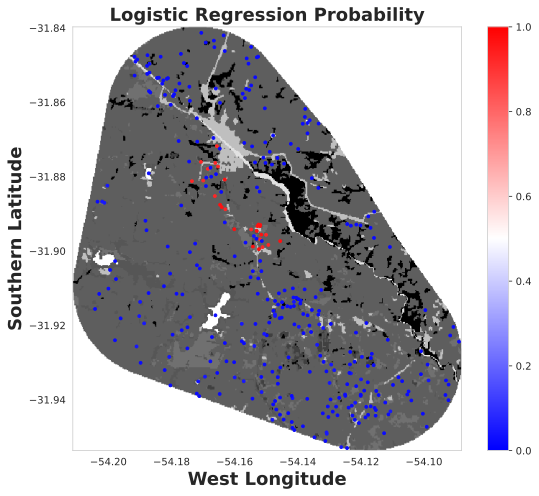

In [ ]:
# MAPS - PROBABILITY

fig, axis = plt.subplots(nrows=1, ncols=1,figsize=(10,7))

# Removing pixels equal to 0
raster_vis_0 = raster_vis[0].where(raster_vis[0] != 0)

# Final model
final_model = aux_grid_dict['Logistic Regression'].best_estimator_

# Test
y_pred = final_model.predict_proba(X_test.drop(['geometry'],axis=1))
y_pred = pd.DataFrame(y_pred[:,1],columns=y_test.columns)

# GeoDataFrame conversion
X_test_copy = X_test.copy()
X_test_copy['LR probability'] = y_pred.values
X_test_copy = gpd.GeoDataFrame(X_test_copy,
                               geometry=X_test_copy['geometry'],
                               crs =df_charcos_pred.crs)

# Plotting
raster_vis_0.plot.imshow(ax=axis, cmap='Greys_r')

# Get current figure and axes
fig = plt.gcf()
ax = plt.gca()

# Remove colorbar from raster
cax = fig.axes[-1]
fig.delaxes(cax)

axis.set_title('Logistic Regression Probability', fontsize=18, fontweight='bold')
X_test_copy.plot(ax=axis, markersize=8, column='LR probability', cmap='bwr', legend=True, vmin=0, vmax=1)
plt.grid(False)

plt.xlabel('West Longitude', fontsize= 18, fontweight='bold')
plt.ylabel('Southern Latitude', fontsize= 18, fontweight='bold')
save_fig("probability_lr",fig_extension="svg")
save_fig("probability_lr",fig_extension="png")
plt.show()

## <b>Training/Testing Splitting: LULC and Nearest Neighbors Invasion State Variables</b>

In [ ]:
# Selección de las variables
df_charcos_pred = df_neighbor_puddles[['State_2007','N1_2007','N2_2007','N3_2007',
                                       'State_2012','N1_2012','N2_2012','N3_2012',
                                       'State_2017','N1_2017','N2_2017','N3_2017',
                                       'State_2022','N1_2022','N2_2022','N3_2022','geometry',
                                       'LULC_val_2007', 'LULC_val_2012',
                                       'LULC_val_2017', 'LULC_val_2022']]

Para esta versión, vamos a considerar únicamente el estado de invasión del charco y sus tres primeros vecinos en el período anterior(independientemente de la distancia entre charcos), el estado de invasión para charco y vecinos en el período actual y el uso de suelo para el período actual (ya que las pruebas para el período anterior nos arrojaron que estas variables no eran relevantes para nuestro problema):

```
X_train = df_charcos_pred[['State_2007','N1_2007','N2_2007','N3_2007',,'N1_2012','N2_2012','N3_2012','LULC_val_2012']]
y_train = df_charcos_pred['State_2012']

X_train = df_charcos_pred[['State_2012','N1_2012','N2_2012','N3_2012','N1_2017','N2_2017','N3_2017','LULC_val_2017']]
y_train = df_charcos_pred['State_2017']

X_test =  df_charcos_pred[['State_2017','N1_2017','N2_2017','N3_2017','N1_2022','N2_2022','N3_2022','LULC_val_2022']]
y_test = df_charcos_pred['State_2022']
```

In [ ]:
# TRAIN SPLIT

lst_years = [['2007','2012'],['2012','2017']]
lst = ['(t-1)','(t)']

charcos_dict = {'geometry':[],
                'Inv(t-1)':[],
                'Inv_1(t-1)':[],
                'Inv_2(t-1)':[],
                'Inv_3(t-1)':[],
                'LULC(t-1)':[],
                'Inv_1(t)':[],
                'Inv_2(t)':[],
                'Inv_3(t)':[],
                'LULC(t)':[],
                'Inv(t)':[]}

df_charcos_pred_train = pd.DataFrame(columns = list(charcos_dict.keys()))

for j in range(0,df_charcos_pred.shape[0]):
    for i in lst_years:
        charcos_dict = {'geometry':[],
                'Inv(t-1)':[],
                'Inv_1(t-1)':[],
                'Inv_2(t-1)':[],
                'Inv_3(t-1)':[],
                'LULC(t-1)':[],
                'Inv_1(t)':[],
                'Inv_2(t)':[],
                'Inv_3(t)':[],
                'LULC(t)':[],
                'Inv(t)':[]}

        for cont,k in enumerate(i):
            charcos_dict['geometry']=df_charcos_pred.loc[j,'geometry']
            charcos_dict['Inv'+lst[cont]] = df_charcos_pred.loc[j,'State_'+k]
            charcos_dict['Inv_1'+lst[cont]] = df_charcos_pred.loc[j,'N1_'+k]
            charcos_dict['Inv_2'+lst[cont]] = df_charcos_pred.loc[j,'N2_'+k]
            charcos_dict['Inv_3'+lst[cont]] = df_charcos_pred.loc[j,'N3_'+k]
            charcos_dict['LULC'+lst[cont]]=df_charcos_pred.loc[j,'LULC_val_'+k]

        df_charcos_pred_train = pd.concat([df_charcos_pred_train, pd.DataFrame([charcos_dict])], ignore_index=True)

# GeoDataFrame conversion
df_charcos_pred_train = gpd.GeoDataFrame(df_charcos_pred_train,
                                         geometry=df_charcos_pred_train['geometry'],
                                         crs =df_charcos_pred.crs)

In [ ]:
# TEST SPLIT

lst_years = [['2017','2022']]
lst = ['(t-1)','(t)']

charcos_dict = {'geometry':[],
                'Inv(t-1)':[],
                'Inv_1(t-1)':[],
                'Inv_2(t-1)':[],
                'Inv_3(t-1)':[],
                'LULC(t-1)':[],
                'Inv_1(t)':[],
                'Inv_2(t)':[],
                'Inv_3(t)':[],
                'LULC(t)':[],
                'Inv(t)':[]}

df_charcos_pred_test = pd.DataFrame(columns = list(charcos_dict.keys()))

for j in range(0,df_charcos_pred.shape[0]):
    for i in lst_years:
        charcos_dict = {'geometry':[],
                'Inv(t-1)':[],
                'Inv_1(t-1)':[],
                'Inv_2(t-1)':[],
                'Inv_3(t-1)':[],
                'LULC(t-1)':[],
                'Inv_1(t)':[],
                'Inv_2(t)':[],
                'Inv_3(t)':[],
                'LULC(t)':[],
                'Inv(t)':[]}

        for cont,k in enumerate(i):
            charcos_dict['geometry']=df_charcos_pred.loc[j,'geometry']
            charcos_dict['Inv'+lst[cont]] = df_charcos_pred.loc[j,'State_'+k]
            charcos_dict['Inv_1'+lst[cont]] = df_charcos_pred.loc[j,'N1_'+k]
            charcos_dict['Inv_2'+lst[cont]] = df_charcos_pred.loc[j,'N2_'+k]
            charcos_dict['Inv_3'+lst[cont]] = df_charcos_pred.loc[j,'N3_'+k]
            charcos_dict['LULC'+lst[cont]]=df_charcos_pred.loc[j,'LULC_val_'+k]

        df_charcos_pred_test = pd.concat([df_charcos_pred_test, pd.DataFrame([charcos_dict])], ignore_index=True)

# GeoDataFrame conversion
df_charcos_pred_test = gpd.GeoDataFrame(df_charcos_pred_test,
                                         geometry=df_charcos_pred_test['geometry'],
                                         crs =df_charcos_pred.crs)

## <b>Model Training/Testing: LULC and Nearest Neighbors Invasion State Variables</b>